In [1]:
### Import the required libraries
%matplotlib widget

import matplotlib.pyplot as plt
from pyLIMA.models import PSBL_model
from pyLIMA.outputs import pyLIMA_plots
### Import the simulator to be used for generating the simulated light curve
from pyLIMA.simulations import simulator
### Import the module to use for the Differential Evolution fit
from pyLIMA.fits import DE_fit
### Import the module to use for orbital motion
from pyLIMA.orbitalmotion import orbital_motion_2D, orbital_motion_3D

from pyLIMA import event

In [2]:
### Creating an event, determining position of event in sky
event_one = event.Event(ra=270, dec=-30)
event_one.name = 'Normal 200 Q'

event_two = event.Event(ra=270, dec=-30)
event_two.name = 'Orbital 200 Q'

In [3]:
### Creating Telescope
SPITZERA_H = simulator.simulate_a_telescope(name='SPITZERA_H', time_start=2459945.5, time_end=2460500.55, sampling=4, location='Space', camera_filter='H',
                                        uniform_sampling=True, spacecraft_name='Spitzer', astrometry=False)

In [4]:
### Appending telescopes
event_one.telescopes.append(SPITZERA_H)

In [5]:
### Sanity Check
event_one.check_event()

check_event  : Everything looks fine...


In [6]:
###Setting up the parameters as a function of the event
psbl1 = PSBL_model.PSBLmodel(event_one, parallax=['Full', 2460100.5])
psbl2 = PSBL_model.PSBLmodel(event_one, parallax=['Full', 2460100.5], orbital_motion=['2D',2460100.5])

Successfully ephemeris from JPL!
Parallax(Full) estimated for the telescope SPITZERA_H: SUCCESS
Parallax(Full) estimated for the telescope SPITZERA_H: SUCCESS


In [7]:
###Setting up the parameters as a function of the event
psbl1_parameters = simulator.simulate_microlensing_model_parameters(psbl1)
psbl2_parameters = simulator.simulate_microlensing_model_parameters(psbl2)

In [8]:
psbl1_parameters[0:9] = [2460100.5, 0.94460, 350, 0.23, 0.005, 0.46504, 1.01163, 1.75219, 2148.8099, 570.79948]
psbl2_parameters[0:12] = [2460100.5, 0.94460, 350, 0.23, 0.005, 0.46504, 1.01163, 1.75219, 2148.8099, 570.79948, 1689.79223, 199.03474]

In [9]:
print(psbl1_parameters)
print(psbl2_parameters)

[2460100.5, 0.9446, 350, 0.23, 0.005, 0.46504, 1.01163, 1.75219, 2148.8099, 570.79948, 238.1832028939087]
[2460100.5, 0.9446, 350, 0.23, 0.005, 0.46504, 1.01163, 1.75219, 2148.8099, 570.79948, 1689.79223, 199.03474]


In [10]:
### Defining the psbl parameters in terms of pyLIMA as an object
pyLIMA_parameters_1 = psbl1.compute_pyLIMA_parameters(psbl1_parameters)
pyLIMA_parameters_2 = psbl2.compute_pyLIMA_parameters(psbl2_parameters)

In [11]:
### Prepping the simulation
simulator.simulate_lightcurve_flux(psbl1, pyLIMA_parameters_1)
simulator.simulate_lightcurve_flux(psbl2, pyLIMA_parameters_2)

Successfully ephemeris from JPL!
Parallax(Full) estimated for the telescope SPITZERA_H: SUCCESS


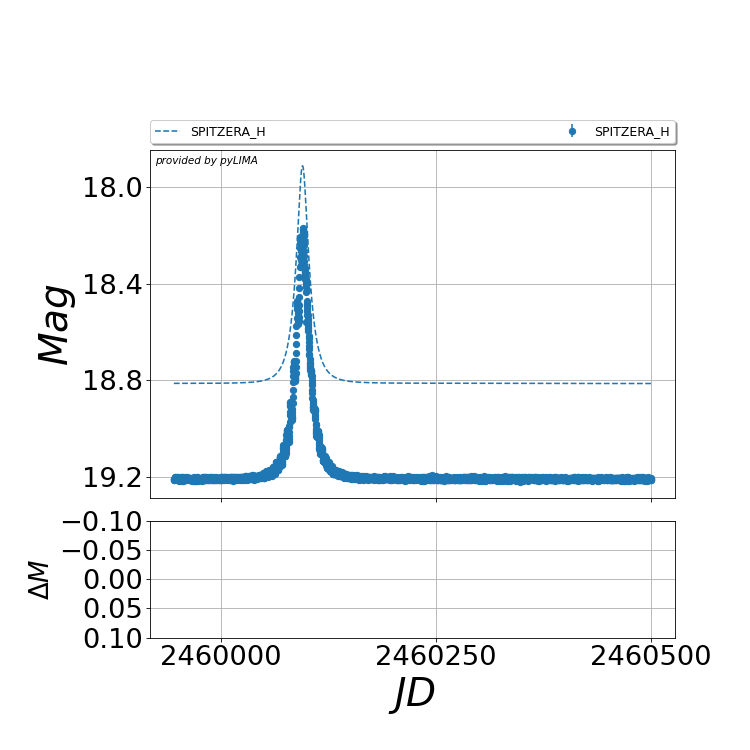

In [12]:
### Plotting the curves
from pyLIMA.outputs import pyLIMA_plots
pyLIMA_plots.plot_lightcurves(psbl1, psbl1_parameters)
plt.show()

Successfully ephemeris from JPL!
Parallax(Full) estimated for the telescope SPITZERA_H: SUCCESS


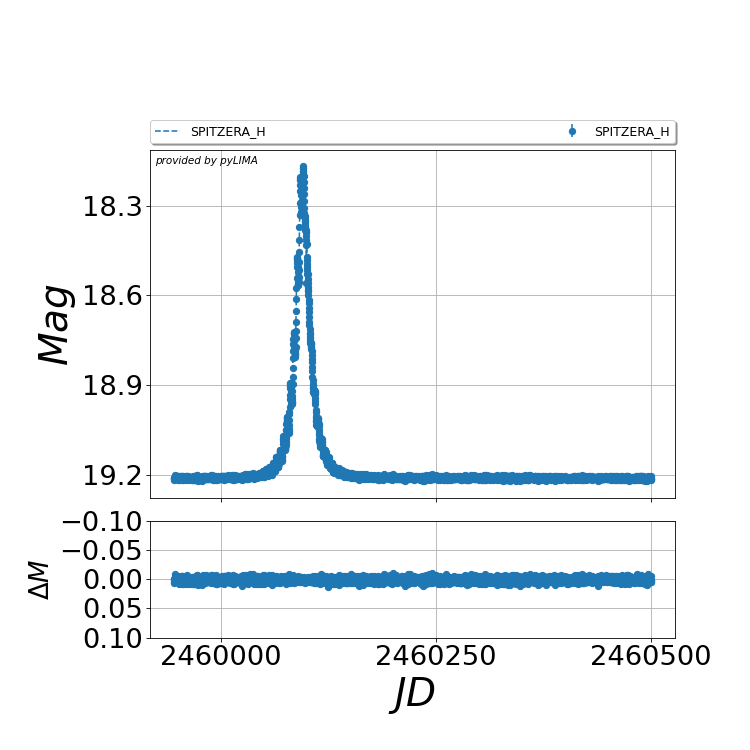

In [13]:
### Plotting the curves
pyLIMA_plots.plot_lightcurves(psbl2, psbl2_parameters)
plt.show()

Successfully ephemeris from JPL!
Parallax(Full) estimated for the telescope SPITZERA_H: SUCCESS
Successfully ephemeris from JPL!
Parallax(Full) estimated for the telescope SPITZERA_H: SUCCESS


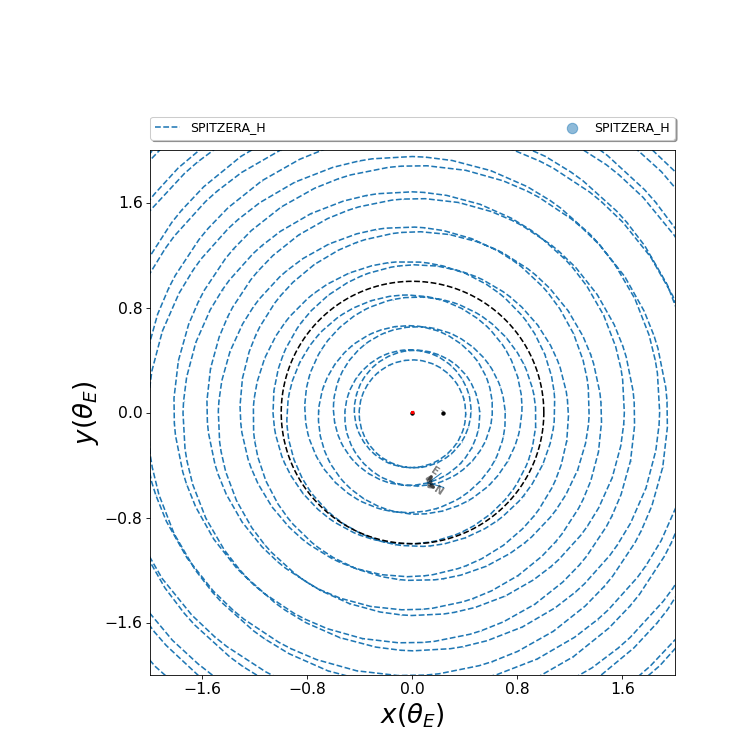

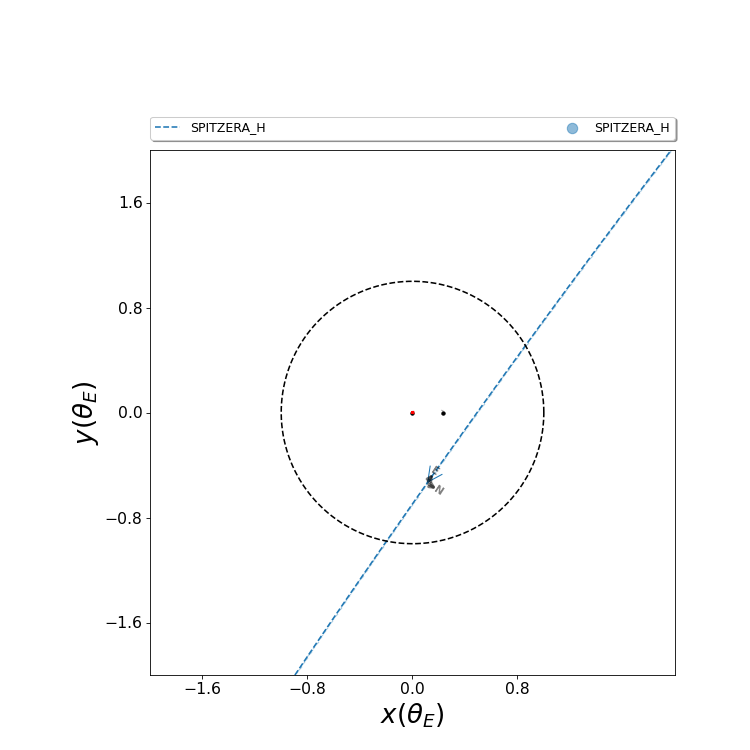

In [14]:
### Plot the geometry of the event:
pyLIMA_plots.plot_geometry(psbl1, psbl1_parameters)
pyLIMA_plots.plot_geometry(psbl2, psbl2_parameters)

plt.show()

In [15]:
import numpy as np
from pyLIMA.outputs import pyLIMA_plots

# Get time and flux for static and orbital models
lightcurve_static = psbl1.event.telescopes[0].lightcurve_flux  # QTable for static model
lightcurve_orbital = psbl2.event.telescopes[0].lightcurve_flux  # QTable for orbital model

# Access time and flux from the QTable
time_static = lightcurve_static['time']  # Extract the time series
flux_static = lightcurve_static['flux']  # Extract the flux

time_orbital = lightcurve_orbital['time']  # Extract the time series
flux_orbital = lightcurve_orbital['flux']  # Extract the flux

# Ensure the time arrays match
if np.array_equal(time_static, time_orbital):
    time = time_static  # Use one of the time arrays as they should match
else:
    raise ValueError("Time arrays for static and orbital models do not match.")

# Calculate residuals
residuals = flux_orbital - flux_static

In [17]:
from astropy.time import Time
import astropy.units as u
import numpy as np

# Assuming `time_static` is the QTable with JD values
# Remove the unit by converting it to a NumPy array or list
jd_values = time_static.value  # Removes the unit

# Convert the JD values into `astropy.time.Time` objects
time_astropy = Time(jd_values, format='jd')
                    
# Choose a reference time, e.g., the first observation
reference_time = time_astropy[0]

# Convert time to a difference relative to the reference time in days
time_days = (time_astropy - reference_time).to_value('day')  # Time difference in days

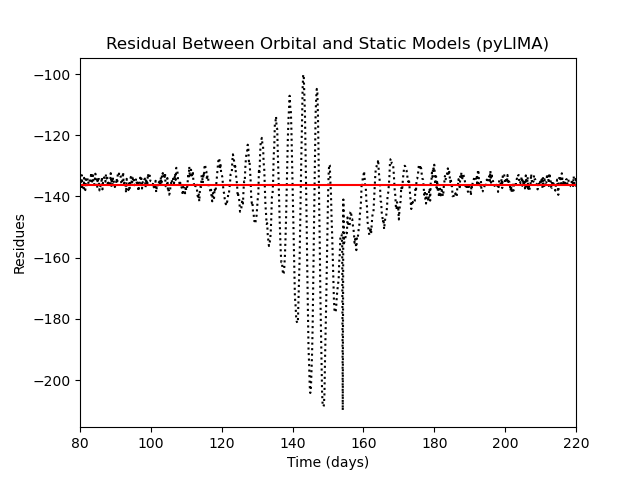

In [97]:
# Compute fit residuals
model = psbl1.compute_the_microlensing_model(SPITZERA_H, pyLIMA_parameters_1)['photometry']
flux = SPITZERA_H.lightcurve_flux['flux'].value
errflux = SPITZERA_H.lightcurve_flux['err_flux'].value
residues = (flux - model)/errflux

fig01 = plt.figure()
plt.plot(time_days, residues, color='blue')
plt.title("Residual Between Orbital and Static Models (pyLIMA)")
plt.axhline(residues.mean(), color='blue', linestyle='--')  # Add a reference line at mean
plt.xlabel("Time (days)")
plt.ylabel("Residues")
plt.xlim(80,220)
plt.show()

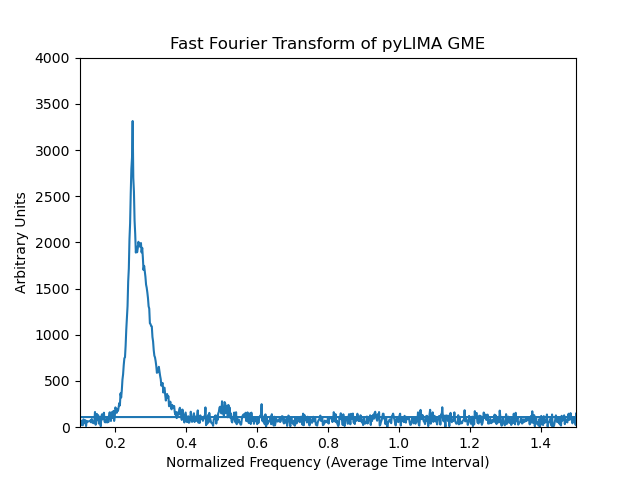

In [79]:
# Perform FFT on the residuals
fft_result = np.fft.fft(residues)
frequencies = np.fft.fftfreq(len(residuals), d=np.mean(np.diff(time_days)))

# Calculate the power spectral density (magnitude of FFT)
fft_magnitude = np.abs(fft_result)

# Plot the FFT results (frequency vs magnitude)
plt.figure()
plt.plot(frequencies, fft_magnitude)
plt.title('Fast Fourier Transform of pyLIMA GME')
plt.xlabel('Normalized Frequency (Average Time Interval)')
plt.ylabel('Arbitrary Units')
plt.xlim(0.1, np.max(frequencies)/2)  
plt.ylim(0,4000)
plt.show()

In [89]:
import pandas as pd

freqs = pd.DataFrame(frequencies)
magnis = pd.DataFrame(fft_magnitude)
comp = pd.DataFrame(frequencies, fft_magnitude).reset_index()
comp = comp.rename(columns = {"index":"frequency", 0:"magnitude"})

# Halving the database due to symmetries in the fourier transform
comp = comp[1:1665]
comp

,frequency,magnitude
1,3232.258185,0.001801
2,3059.046986,0.003603
3,2918.069289,0.005404
4,2827.328564,0.007205
5,2666.657379,0.009006
...,...,...
1660,47.593251,2.990093
1661,51.842281,2.991894
1662,70.693005,2.993696
1663,93.047132,2.995497


In [92]:
# Selecting the median from the peak
comp[(comp["magnitude"] > 0.2) & (comp["magnitude"] < 0.4)].median()

# Selecting for the values closest to the frequency in the dataframe
comp.iloc[(comp['frequency']-594.929803).abs().argsort()[:5]]

,frequency,magnitude
178,594.929803,0.320624
180,600.921136,0.324227
176,588.577025,0.317022
177,617.753323,0.318823
123,571.026229,0.221555


In [93]:
# Using the median of the peak to identify the planet's period
freqs = pd.DataFrame(frequencies)
max_p = freqs.iloc[178]
1/max_p

0    3.118914
Name: 178, dtype: float64